![network_topology.png](attachment:network_topology.png)


-------
## Get the streamflow data from the HYDAT data


| Gauge name | Gauge ID | Variable |
| --- | --- | --- |
| SWIFT CURRENT CREEK NEAR LEINAN | 05HD039  | Discharge |
| ELBOW DIVERSION CANAL AT DROP STRUCTURE | 05JG006  | Discharge |
| SOUTH SASKATCHEWAN RIVER AT SASKATOON | 05HG001  | Discharge |
| RED DEER RIVER NEAR BINDLOSS | 05CK004  | Discharge |
| SOUTH SASKATCHEWAN RIVER AT MEDICINE HAT | 05AJ001  | Discharge |
| LAKE DIEFENBAKER AT GARDINER DAM | 05HF003  | Water level |

Three of the upstream stations of Lake Diefenbaker, 05HD039, 05AJ001, and 05CK004 are included as injection varibale with positive values, 05JG006 is treated as abstraction with negative values. Water level information is used to force mizuRoute.

## the following code is adapted from EASYMORE examples

In [26]:
import requests
from   bs4 import BeautifulSoup
import os
import glob
from   zipfile import ZipFile
import pandas as pd
import sqlite3
import datetime
import xarray as xr
import numpy as np


def HYDAT_download(url, folder_to_save): # downlaod and unzip

    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    links = []
    for link in soup.find_all("a"):
        href = link.get("href")
        if href and href.startswith("Hydat_sqlite3") and href.endswith(".zip"):
            links.append(href)

    if len(links) == 1:
        HYDAT_link = url+links[0]
    else:
        print('There are multiple files in links')

    if not os.path.isdir(folder_to_save):
        os.makedirs(folder_to_save)

    r = requests.get(HYDAT_link) # download the URL
    # print the specification of the download 
    print(r.status_code, r.headers['content-type'], r.encoding)
    # if download successful the statuse code is 200 then save the file, else print what was not downloaded
    if r.status_code == 200:
        print('download was successful for '+url)
        with open(folder_to_save+ 'HYDAT.zip', 'wb') as f:
            f.write(r.content)
    else:
        print('download was not successful for '+url)
    
    # unzip the folder
    name_zips = glob.glob(folder_to_save+ 'HYDAT.zip')  # getting the name of the all the downloaded zip file in one directory
    # loop over the zip file names and unzip them
    for name_zip in name_zips:
        with ZipFile(name_zip, 'r') as zipObj:
            # Extract all the contents of zip file in different directory
            folder_name = name_zip[:-4] # removing the zip extension (.zip)
            zipObj.extractall(folder_to_save)
            
def extract_station_daily_flow(
    station: str,
    connection: str, # sqlite3 file location
    start_date: str = '1850-01-01',
    end_date: str = str(datetime.datetime.now().date()),
    *args,
    **kwargs,
) -> pd.DataFrame:
    
    '''
    This function simply extracts data from the HYDAT sqlite3 database
    '''
    
    connection = sqlite3.connect(connection)
    
    # read station data
    df = pd.read_sql_query(f"SELECT * FROM DLY_FLOWS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    # set index
    df.set_index(keys=['STATION_NUMBER', 'YEAR', 'MONTH'], drop=True, inplace=True)
    
    # get the FLOW and FLAG
    df_flow = get_the_daily_dataframe(df, r'^FLOW\d', 'FLOW')
    df_flag = get_the_daily_dataframe(df, r'^FLOW_.', 'FLAG')
    
    #
    df_flow.sort_index(axis=0, inplace=True)
    df_flow.sort_index(axis=1, level=0, ascending=False, inplace=True)
    df_flow.columns = df_flow.columns.droplevel(1)
    df_flow.columns.name = None
    
    df_flag.sort_index(axis=0, inplace=True)
    df_flag.sort_index(axis=1, level=0, ascending=False, inplace=True)
    df_flag.columns = df_flag.columns.droplevel(1)
    df_flag.columns.name = None
    
    df_flow = df_flow.loc[start_date:end_date, :]
    df_flag = df_flag.loc[start_date:end_date, :]
    
    # stations information
    df_info = pd.read_sql_query(f"SELECT * FROM STATIONS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    return df_flow, df_flag, df_info

def extract_station_daily_level(
    station: str,
    connection: str, # sqlite3 file location
    start_date: str = '1850-01-01',
    end_date: str = str(datetime.datetime.now().date()),
    *args,
    **kwargs,
) -> pd.DataFrame:
    
    '''
    This function simply extracts data from the HYDAT sqlite3 database
    '''
    
    connection = sqlite3.connect(connection)
    
    # read station data
    df = pd.read_sql_query(f"SELECT * FROM DLY_LEVELS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    # set index
    df.set_index(keys=['STATION_NUMBER', 'YEAR', 'MONTH'], drop=True, inplace=True)
    
    print(df)
    
    # get the FLOW and FLAG
    df_flow = get_the_daily_dataframe(df, r'^LEVEL\d', 'LEVEL')
    df_flag = get_the_daily_dataframe(df, r'^LEVEL_.', 'FLAG')
    
    print(df_flow)
    print(df_flag)
    
    #
    df_flow.sort_index(axis=0, inplace=True)
    df_flow.sort_index(axis=1, level=0, ascending=False, inplace=True)
    df_flow.columns = df_flow.columns.droplevel(1)
    df_flow.columns.name = None
    
    df_flag.sort_index(axis=0, inplace=True)
    df_flag.sort_index(axis=1, level=0, ascending=False, inplace=True)
    df_flag.columns = df_flag.columns.droplevel(1)
    df_flag.columns.name = None
    
    df_flow = df_flow.loc[start_date:end_date, :]
    df_flag = df_flag.loc[start_date:end_date, :]
    
    # stations information
    df_info = pd.read_sql_query(f"SELECT * FROM STATIONS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    return df_flow, df_flag, df_info

def get_the_daily_dataframe(
    df: pd.DataFrame,
    regex_str: str,
    col: str,
    *args,
    **kwargs,
) -> pd.DataFrame:
    
    # filter and trim columns
    df = df.filter(regex=regex_str, axis=1) # extract the columns
    df.columns = df.columns.str.replace(r'\D', '', regex=True) # remove non-digits
    df = df.stack(dropna=False) # stack without dropping
    df.index.names = ['STATION_NUMBER', 'YEAR', 'MONTH', 'DAY'] # assign index names
    df = df.reset_index() # reset index to add another level
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']].astype(str).agg('-'.join, axis=1),\
                                errors='coerce') # define date column
    df.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True) # drop unnecessary columns
    df.dropna(subset=['DATE'], inplace=True) # remove invalid dates
    df.set_index(keys=['STATION_NUMBER', 'DATE'], drop=True, inplace=True) # set index levels
    df.columns = [col] # assing column name
    
    # pivot data to look nice
    df = df.unstack(level='STATION_NUMBER')
    df = df.reorder_levels(order=[1,0], axis=1)
    
        
    return df
            

url = "https://collaboration.cmc.ec.gc.ca/cmc/hydrometrics/www/" # url may not change but better to check
folder_to_save = '../data/HYDAT/' # place where the files are saved

# download the HYDAT data if already not donwloaded
HYDAT_download(url, folder_to_save)

# stations with flow
for station in ['05HD039','05JG006','05HG001','05CK004','05AJ001']:
    df_flow, df_flag, df_info = [],[],[]
    df_flow, df_flag, df_info = extract_station_daily_flow (station,\
                                                            folder_to_save+'Hydat.sqlite3',\
                                                            '1850-01-01',\
                                                            str(datetime.datetime.now().date()),)
    df_flow.to_csv(folder_to_save+station+'_flow.csv')
    df_flag.to_csv(folder_to_save+station+'_flag.csv')
    df_info.to_csv(folder_to_save+station+'_info.csv')

# station with water level
for station in ['05HF003']:
    df_flow, df_flag, df_info = [],[],[]
    df_level, df_flag, df_info = extract_station_daily_level(station,\
                                                             folder_to_save+'Hydat.sqlite3',\
                                                             '1850-01-01',\
                                                             str(datetime.datetime.now().date()),)
    df_level.to_csv(folder_to_save+station+'_level.csv')
    df_flag.to_csv(folder_to_save+station+'_flag.csv')
    df_info.to_csv(folder_to_save+station+'_info.csv')


# remove the large source files not to include the git commit
os.remove(folder_to_save+'Hydat.sqlite3')
os.remove(folder_to_save+'HYDAT.zip')



                           PRECISION_CODE  FULL_MONTH  NO_DAYS  MONTHLY_MEAN  \
STATION_NUMBER YEAR MONTH                                                      
05HF003        1964 12                  8           0       31           NaN   
               1965 1                   8           0       31           NaN   
                    2                   8           0       28           NaN   
                    3                   8           0       31           NaN   
                    4                   8           0       30           NaN   
...                                   ...         ...      ...           ...   
               2021 8                   8           1       31    553.393005   
                    9                   8           0       30           NaN   
                    10                  8           1       31    553.250000   
                    11                  8           1       30    553.197021   
                    12                  

             DATE     05HF003
0      1964-12-01         NaN
1      1964-12-02         NaN
2      1964-12-03         NaN
3      1964-12-04         NaN
4      1964-12-05         NaN
...           ...         ...
20755  2021-12-27  552.594971
20756  2021-12-28  552.572021
20757  2021-12-29  552.556030
20758  2021-12-30  552.525024
20759  2021-12-31  552.512024

[20760 rows x 2 columns]


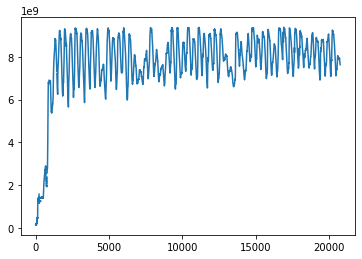

In [31]:
## convert the water level to volume for Lake Diefenbaker
level = pd.read_csv(folder_to_save+'05HF003_level.csv')
ele_str = pd.read_csv('../data/Elevation_Storage/Storage_Elevation_Diefenbaker.csv')

volume = level.copy()
print(volume)


volume ['05HF003'] = np.interp(volume ['05HF003'], ele_str['Elevation(m)'], ele_str['Storage(m^3)'])

volume['05HF003'].plot()

volume.to_csv(folder_to_save+'05HF003_volume.csv')



In [32]:
volume

DATE       05HF003
0      1964-12-01           NaN
1      1964-12-02           NaN
2      1964-12-03           NaN
3      1964-12-04           NaN
4      1964-12-05           NaN
...           ...           ...
20755  2021-12-27  7.657399e+09
20756  2021-12-28  7.649426e+09
20757  2021-12-29  7.643871e+09
20758  2021-12-30  7.633100e+09
20759  2021-12-31  7.628584e+09

[20760 rows x 2 columns]